In [1]:
#Estudante: Fabrizio Honda Franzoia
#Matrícula: 2230647
#Curso: Mestrado em Informática (PPGI)
#Disciplina: ICC220 - TEBD (para CC e ES) 2024/01 PPGINF528 - TERI 2024/01
#Trabalho Prático 3 (TP3): Large Language Model (LLM) sobre Legislação Acadêmica da UFAM

#LINKS IMPORTANTES

#Relatório da Atividade: https://drive.google.com/file/d/1dVeT3xqsSrm8xUyY7DH5wWsfq9NdwGFN/view?usp=sharing
#Modelo em .zip (se necessário): https://drive.google.com/file/d/1PJoXVOBA_bXem5vDDzvTOATIpT9Z9NrR/view?usp=sharing
#Base sintética (arquivo JSON): https://drive.google.com/file/d/1Dt0L8uen4FgZkSE8tpohJfbhr-FTA1ft/view?usp=sharing
#Corpus (arquivo TXT): https://drive.google.com/file/d/1_on1Bv6KiVzf41dck5VS_K-gaueYg6Nx/view?usp=sharing

#OBS: este notebook contém tanto o modelo treinado quanto o Sistema RAG Implementado



---



**Etapa 1 - Preparação do Ambiente**
- Configuração do *Google Colaboratory*
- Instalação das bibliotecas necessárias

In [2]:
# Instalação das bibliotecas necessárias
!pip install transformers datasets loralib whoosh sacrebleu

# Importação das bibliotecas necessárias
import json, os, torch, numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from google.colab import files, drive
from datasets import Dataset, load_metric
import loralib as lora
from whoosh.index import create_in, open_dir
from whoosh.fields import Schema, TEXT
from whoosh.qparser import QueryParser
from IPython.display import display, HTML
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments, Seq2SeqTrainer,
    get_linear_schedule_with_warmup
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Fo



---



**Etapa 2 - Envio dos arquivos necessários**
- Upload dos arquivos .JSON e .txt, referentes a, respectivamente, perguntas/respostas sobre a Legislação Acadêmica da UFAM e o *corpus* de texto sobre a mesma.
- Preparação do Woosh para a indexação do corpus de texto, que será utilizado para RAG (*Retrieval Augmented Generation*).

OBS¹: os arquivos estão disponíveis no início desse notebook, cujos links estão em comentários.

OBS²: diante do tamanho do arquivo e os desafios em gerar perguntas distintas sobre o *corpus*, optou-se pela composição da base sintética com somente 100 perguntas/resposta (todas distintas).

In [3]:
# Carregamento do JSON no Google Colab (perguntas e respostas sobre a Legislação Acadêmica da UFAM)
display(HTML('<h4>Faça o upload do arquivo .JSON (perguntas e respostas sobrea a Legislação Acadêmica da UFAM)</h4>'))
uploaded = files.upload()

# Definição do nome do arquivo JSON carregado
file_name_json = list(uploaded.keys())[0]

# Abertura e leitura do arquivo JSON
with open(file_name_json, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Carregamento do corpus de texto no Google Colab (arquivo .txt com a Legislação Acadêmica da UFAM)
display(HTML('<h4>Faça o upload do arquivo .txt (corpus da Legislação Acadêmica da UFAM)</h4>'))
uploaded_txt = files.upload()
file_name_txt = list(uploaded_txt.keys())[0]

# Especificação do esquema do Whoosh
schema = Schema(content=TEXT(stored=True))

# Criação do diretório de índice, se não existir
if not os.path.exists("indexdir"):
    os.mkdir("indexdir")

# Criação do índice Whoosh
ix = create_in("indexdir", schema)

# Indexação do corpus de texto
writer = ix.writer()
with open(file_name_txt, 'r', encoding='utf-8') as f:
    for line in f:
        writer.add_document(content=line.strip())
writer.commit()

# Verificação da conclusão da indexação
print(f"Indexação completa.")

# Abertura do índice e verificação dos primeiros documentos indexados
ix = open_dir("indexdir")
with ix.searcher() as searcher:
    results = searcher.documents()
    for i, result in enumerate(results):
        if i < 5:  # Impressão dos primeiros 5 documentos para verificação
            print(f"Documento {i}: {result['content'][:100]}...")

Saving legislacao_academica_base.json to legislacao_academica_base.json


Saving legislacao_academica_corrigido.txt to legislacao_academica_corrigido.txt
Indexação completa.
Documento 0: TÍTULO I...
Documento 1: ...
Documento 2: DA UNIVERSIDADE...
Documento 3: ...
Documento 4: Art. 1º – A Universidade do Amazonas, com sede na cidade de Manaus, é uma Instituição Federal de Ens...




---



**Etapa 3 - Treinamento do modelo de linguagem com LoRA**
- Utilização do modelo PPT5 para treino, visto que é focado em português brasileiro.
- Treinamento do modelo a partir do arquivo JSON com as perguntas e respostas sobre a Legislação Acadêmica da UFAM (base sintética), fazendo uso de *Low-Rank Adaptation* (LoRA) para o *tuning* de instruções.
- Cálculo do loss de treinamento e validação, além da perplexidade do modelo
- Análise do desempenho das respostas geradas pelo modelo, através de BLEU (*Bilingual Evaluation Understudy*)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/756k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at unicamp-dl/ptt5-base-portuguese-vocab and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/90 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,126.706400,138.214050
2,103.431700,91.147194
4,68.193400,41.356365
6,30.299000,20.105953
8,18.239500,10.249464
10,10.692700,4.341922
12,5.993000,2.526993
14,2.627500,2.012302
16,1.923000,1.607291
18,1.554200,1.365169


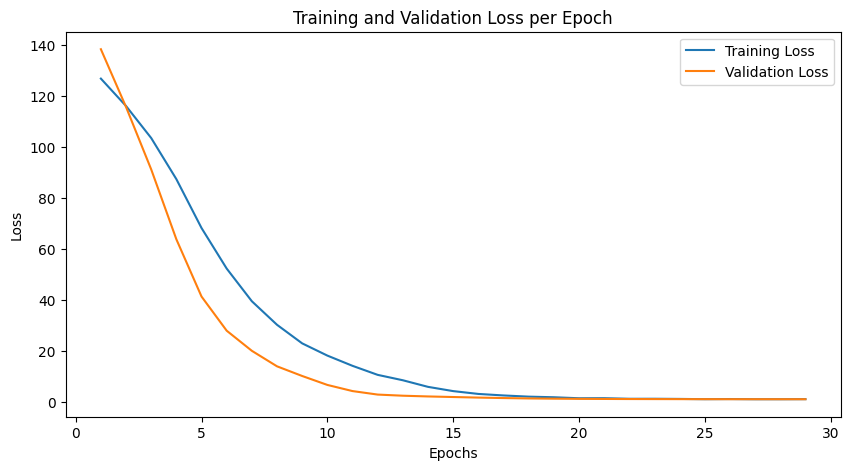

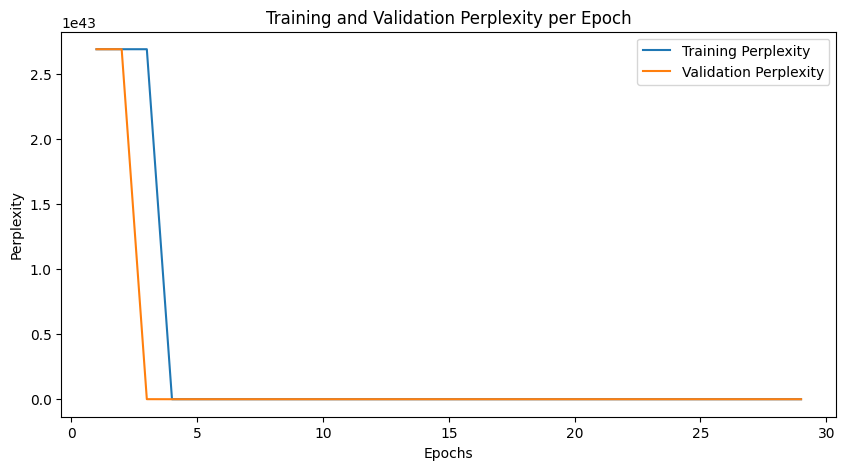

In [4]:
# Transformação dos dados em um formato apropriado para treinamento
train_data = [{"instruction": item["pergunta"], "response": item["resposta"]} for item in data]

# Preparação dos Dados
dataset = Dataset.from_list(train_data)
dataset = dataset.train_test_split(test_size=0.1)

# Carregamento do Modelo e Tokenizer
model_name = "unicamp-dl/ptt5-base-portuguese-vocab"  # Modelo em português (derivado do T5)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, tie_word_embeddings=False)  # Desativação do compartilhamento de peso

# Modificação das camadas de atenção para usar LoRA
def modify_with_lora(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            if 'q' in name or 'v' in name:  # Aplicação do LoRA apenas às camadas 'q' e 'v'
                lora.mark_only_lora_as_trainable(module)
                lora.Linear(module.in_features, module.out_features, r=8)

modify_with_lora(model)
model.train()

# Função para pré-processamento dos dados
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["instruction"], max_length=512, padding="max_length", truncation=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["response"], max_length=512, padding="max_length", truncation=True
        )

    # Ajuste para garantir compatibilidade com o modelo
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Pré-processamento dos dados
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Configuração dos Argumentos de Treinamento
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=30,
    fp16=True,
    push_to_hub=False,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=10
)

# Inicialização do Treinador
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

# Cálculo do Número Total de Passos de Treinamento
total_steps = len(tokenized_datasets["train"]) // training_args.gradient_accumulation_steps * training_args.num_train_epochs

# Inicialização do Otimizador e do Agendador de Taxa de Aprendizado
trainer.create_optimizer_and_scheduler(num_training_steps=total_steps)

# Criação do Agendador de Taxa de Aprendizado
scheduler = get_linear_schedule_with_warmup(
    optimizer=trainer.optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

trainer.lr_scheduler = scheduler

# Treinamento do Modelo
trainer.train()

# Salvamento do Modelo Treinado
trainer.save_model("./legislation-model")
tokenizer.save_pretrained("./legislation-tokenizer")

# Coleta dos Valores de Loss
train_loss = []
eval_loss = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Garantia de que os Arrays tenham o Mesmo Comprimento
min_len = min(len(train_loss), len(eval_loss))
train_loss = train_loss[:min_len]
eval_loss = eval_loss[:min_len]

# Plotagem do Gráfico de Desempenho do Loss por Época
epochs = range(1, min_len + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss per Epoch')
plt.show()

# Cálculo da Perplexidade
def calculate_perplexity(loss):
    return np.exp(min(loss, 100))  # Limita a perda máxima a 100 para evitar explosão

train_perplexity = [calculate_perplexity(loss) for loss in train_loss]
eval_perplexity = [calculate_perplexity(loss) for loss in eval_loss]

# Plotagem do Gráfico de Desempenho da Perplexidade por Época
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_perplexity, label='Training Perplexity')
plt.plot(epochs, eval_perplexity, label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.title('Training and Validation Perplexity per Epoch')
plt.show()

In [18]:
# Verificação de disponibilidade da GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregamento da métrica BLEU
bleu_metric = load_metric("sacrebleu")

# Função para calcular a métrica BLEU
def compute_bleu(predictions, references):
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(references, skip_special_tokens=True)
    decoded_labels = [[label] for label in decoded_labels]
    result = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return result["score"]

# Avaliação do modelo
model.eval()
predictions = []
references = []

batch_size = 4  # Tamanho do lote para processamento (reduzido para evitar problemas de memória)

for i in range(0, len(tokenized_datasets), batch_size):
    batch = tokenized_datasets.select(range(i, min(i + batch_size, len(tokenized_datasets))))
    input_ids = torch.tensor(batch["input_ids"]).to(device)
    labels = torch.tensor(batch["labels"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)

    with torch.no_grad():
        outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=512, num_beams=5, early_stopping=True)

    predictions.extend(outputs)
    references.extend(labels)

# Impressão das previsões e referências para verificação
decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(references, skip_special_tokens=True)

for i in range(5):
    print(f"Prediction: {decoded_preds[i]}")
    print(f"Reference: {decoded_labels[i]}")

# Cálculo da pontuação BLEU
bleu_score = compute_bleu(predictions, references)
print("BLEU Score:", bleu_score)

Prediction: 
Reference: A sede da Universidade do Amazonas é na cidade de Manaus.
Prediction: 
Reference: A Universidade do Amazonas foi criada em 12 de junho de 1962.
Prediction: 
Reference: O Decreto no 53.699, de 13 de março de 1964, manteve a Universidade do Amazonas como entidade da administração indireta.
Prediction: 
Reference: A Universidade do Amazonas goza de autonomia didático-científica, administrativa e de gestão financeira e patrimonial.
Prediction: 
Reference: A organização e o funcionamento da Universidade do Amazonas são regidos pelo Estatuto, o Regimento Geral e os regimentos das unidades acadêmicas.
BLEU Score: 0.0




---



**Etapa 4 - Implementação de RAG**
- Aplicação de RAG após o treinamento com a base sintética. A partir de perguntas de treino, o modelo retorna uma resposta diretamente da base treinada, se for idêntica. Em caso contrário, analisa o *corpus* e retorna conteúdos relevantes ao contexto informado.
- Utilização de palavras-chave para consultar o *corpus*, visto que anteriormente o modelo tentava procurar a pergunta como um todo e não encontrava.

In [19]:
# Carregamento do modelo e do tokenizer treinados
model_dir = "./legislation-model"  # Diretório onde o modelo treinado foi salvo
tokenizer_dir = "./legislation-tokenizer"  # Diretório onde o tokenizer treinado foi salvo

tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

# Carregamento do arquivo JSON
with open(file_name_json, 'r', encoding='utf-8') as file:
    qa_data = json.load(file)

# Função para buscar a resposta no JSON
def search_in_json(query):
    for item in qa_data:
        if query.lower() == item["pergunta"].lower():
            return item["resposta"]
    return None

# Função para extrair palavras-chave de uma consulta
def extract_keywords(query):
    keywords = query.lower().split()
    return " OR ".join(keywords)

# Função para recuperar textos relevantes usando Whoosh com verificação de relevância
def retrieve_relevant_texts(query, index_name, top_k=10):
    ix = open_dir(index_name)
    qp = QueryParser("content", schema=ix.schema)

    # Extração de palavras-chave da consulta
    keywords = extract_keywords(query)
    q = qp.parse(keywords)

    with ix.searcher() as searcher:
        results = searcher.search(q, limit=top_k)
        retrieved_texts = [result['content'] for result in results]
        print(f"Query: {query}")
        print(f"Retrieved {len(retrieved_texts)} relevant texts")
        for text in retrieved_texts:
            print(f" - {text[:100]}...")  # Impressão de uma prévia de cada texto recuperado
        return retrieved_texts

# Função de geração de respostas com textos contextuais
def generate_response_with_retrieval(model, tokenizer, query, index_name):
    # Busca inicial da resposta no JSON
    json_response = search_in_json(query)
    if json_response:
        return json_response

    # Busca no corpus indexado se não encontrado no JSON
    relevant_texts = retrieve_relevant_texts(query, index_name)
    if not relevant_texts:
        return "Desculpe, não encontrei uma resposta para essa pergunta. Tente reformulá-la."

    # Limitação do contexto para evitar sobrecarregar o modelo
    context = "\n\n".join(relevant_texts[:3])

    # Verificação da relevância do contexto
    if len(context.strip()) == 0:
        return "Desculpe, não encontrei uma resposta para essa pergunta. Tente reformulá-la."

    # Utilização do modelo treinado para gerar a resposta com base no contexto
    input_text = f"Contexto: {context}\n\nPergunta: {query}\nResposta:"
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model.generate(inputs, max_length=150, num_beams=5, early_stopping=True)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Verificação da resposta gerada
    if response.strip() == "":
        response = "Desculpe, não encontrei uma resposta para essa pergunta. Tente reformulá-la."

    return response

# Função para testar as instruções
def test_model_with_retrieval(test_instructions):
    for instruction in test_instructions:
        response = generate_response_with_retrieval(model, tokenizer, instruction, "indexdir")
        print(f"Pergunta: {instruction}")
        print(f"Resposta: {response}\n")

# Teste do modelo com exemplos de perguntas
test_instructions = [
    "Qual é a sede da Universidade do Amazonas?",
    "Quando foi criada a Universidade do Amazonas?",
    "Quais são os princípios que a Universidade deve obedecer?",
    "O que rege a organização e o funcionamento da Universidade?",
    "Qual é a finalidade da Universidade?"
]

# Execução da função de teste
test_model_with_retrieval(test_instructions)

# Função para perguntar ao usuário
def ask_user_question():
    while True:
        user_question = input("Digite sua pergunta (ou 'sair' para encerrar): ")
        if user_question.lower() == 'sair':
            break

        response = generate_response_with_retrieval(model, tokenizer, user_question, "indexdir")
        print(f"Resposta: {response}\n")

# Permissão para que o usuário informe uma pergunta via prompt
ask_user_question()

Pergunta: Qual é a sede da Universidade do Amazonas?
Resposta: A sede da Universidade do Amazonas é na cidade de Manaus.

Query: Quando foi criada a Universidade do Amazonas?
Retrieved 10 relevant texts
 - ### Universidade Federal do Amazonas...
 - ### REGIMENTO GERAL DA UNIVERSIDADE FEDERAL DO AMAZONAS...
 - **CONSIDERANDO** o art. 105 do Regimento Geral da Universidade Federal do Amazonas,...
 - CONSIDERANDO o que dispõe o artigo 39, inciso I do Regimento Geral da Universidade Federal do Amazon...
 - A medalha do Mérito Universitário, prevista no Estatuto da Universidade Federal do Amazonas, será co...
 - - III. cumprir e fazer cumprir as disposições do Estatuto da Universidade, deste Regimento Geral e d...
 - - XIII. cumprir e fazer cumprir as disposições do Estatuto da Universidade, deste Regimento Geral e ...
 - - III. cumprir e fazer cumprir as disposições do Estatuto da Universidade, deste Regimento Geral e d...
 - - XIII. cumprir e fazer cumprir as disposições do Estatuto da Un



---



**Etapa 5 - *Download* do modelo**
- Download do modelo, caso, por algum motivo, não funcione via Google Colab.

In [20]:
# Salvamento do estado dos parâmetros do modelo
torch.save(model.state_dict(), "Fabrizio_Honda_TP3_NLP.pt")

# Compactação do arquivo do modelo para facilitar o download
!zip Fabrizio_Honda_TP3_NLP.zip Fabrizio_Honda_TP3_NLP.pt

# Montagem do Google Drive
drive.mount('/content/drive')

# Cópia do arquivo zipado para o Google Drive
!cp Fabrizio_Honda_TP3_NLP.zip /content/drive/MyDrive/

print("O arquivo foi salvo no Google Drive na pasta 'MyDrive'.")

  adding: Fabrizio_Honda_TP3_NLP.pt (deflated 19%)
Mounted at /content/drive
O arquivo foi salvo no Google Drive na pasta 'MyDrive'.
